In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import requests
from io import BytesIO

import torch
from torch import nn
import torchvision.transforms as T
import torchinfo
from PIL import Image
import matplotlib.pyplot as plt

from dataset import  make_val_aug
from alexnet import AlexNet as MyAlexNet

# Train dataset image means
AlexNet vs ImageNet

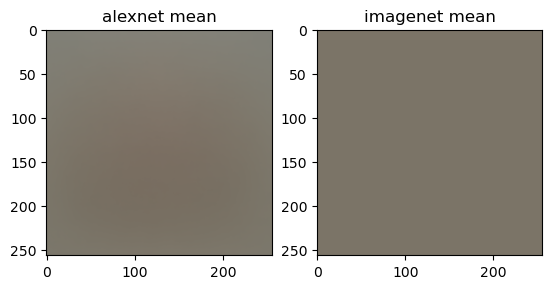

In [3]:
fig, axs = plt.subplots(1, 2)
alexnet_mean = torch.load("train_img_mean.pt")
imagenet_mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None].broadcast_to(-1, 256, 256)
axs[0].imshow(alexnet_mean.permute(1,2,0))
axs[0].set_title("alexnet mean")
axs[1].imshow(imagenet_mean.permute(1,2,0))
axs[1].set_title("imagenet mean")
plt.show()

# Local Response Normalization
What does that layer do? (visually)

In [4]:
def download_image(link: str):
    return Image.open(BytesIO(requests.get(link).content)).convert("RGB")

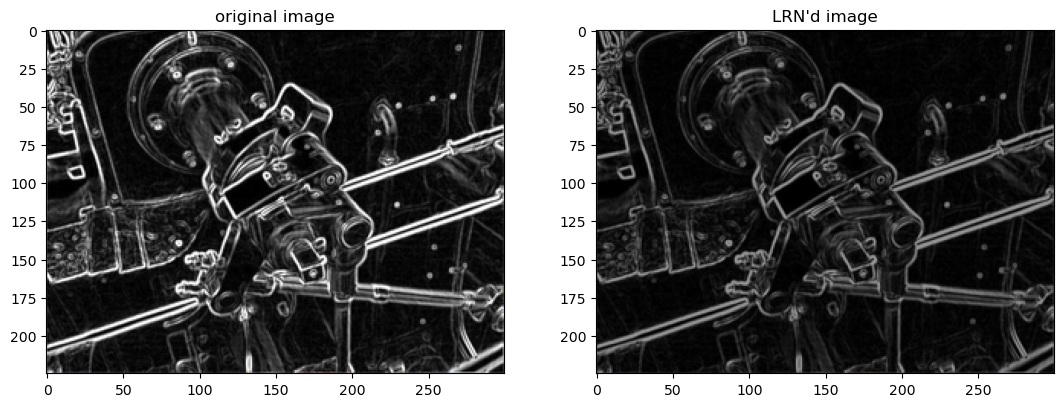

In [5]:
# download interesting images
orig_image = download_image("https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Valve_sobel_%283%29.PNG/300px-Valve_sobel_%283%29.PNG")

fig, axs = plt.subplots(1, 2, figsize=(13, 20))
axs[0].imshow(orig_image, cmap="Greys_r", vmin=0, vmax=255)
axs[0].set_title("original image")
mod_image = T.ToTensor()(orig_image)
mod_image = nn.LocalResponseNorm(size=3, alpha=1e-4, beta=0.75, k=2)(mod_image)
mod_image = T.ToPILImage()(mod_image)
axs[1].imshow(mod_image, cmap="Greys_r", vmin=0, vmax=255)
axs[1].set_title("LRN'd image")
plt.show()

# Try AlexNet
Note that this is only trained on subset of ImageNet

In [6]:
alexnet = MyAlexNet()
alexnet.load_state_dict(torch.load("alexnet.pt"))
fake_inp = torch.randn(5, 3, 224, 224)
print(torchinfo.summary(alexnet, input_data=fake_inp))  # should match figure in the paper
alexnet.debug_forward(fake_inp)
alexnet_mean = torch.load("train_img_mean.pt")
val_aug = make_val_aug(alexnet_mean)
imagenet_labels = eval(requests.get("https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt").text)

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [5, 1000]                 --
├─Sequential: 1-1                        [5, 96, 55, 55]           --
│    └─Conv2d: 2-1                       [5, 96, 55, 55]           34,944
│    └─ReLU: 2-2                         [5, 96, 55, 55]           --
│    └─LocalResponseNorm: 2-3            [5, 96, 55, 55]           --
├─Sequential: 1-2                        [5, 256, 27, 27]          --
│    └─MaxPool2d: 2-4                    [5, 96, 27, 27]           --
│    └─Conv2d: 2-5                       [5, 256, 27, 27]          614,656
│    └─ReLU: 2-6                         [5, 256, 27, 27]          --
│    └─LocalResponseNorm: 2-7            [5, 256, 27, 27]          --
├─Sequential: 1-3                        [5, 384, 13, 13]          --
│    └─MaxPool2d: 2-8                    [5, 256, 13, 13]          --
│    └─Conv2d: 2-9                       [5, 384, 13, 13]          885,120
│

0.76% whiskey jug
0.55% wire-haired fox terrier
0.54% Japanese spaniel
0.42% Maltese dog, Maltese terrier, Maltese
0.36% Siberian husky


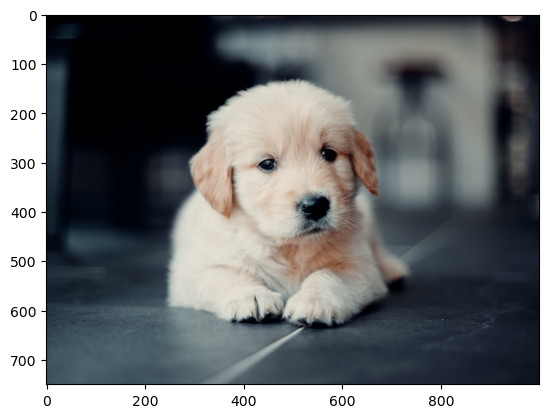

In [7]:
demo_image = download_image("https://images.unsplash.com/photo-1611003228941-98852ba62227?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8Mnx8YmFieSUyMGRvZ3xlbnwwfHwwfHx8MA%3D%3D&w=1000&q=80")
inp = val_aug(demo_image)

alexnet.eval()
with torch.no_grad():
    pred = alexnet(inp.unsqueeze(0)).squeeze()
top5_value, top5_idx = pred.softmax(-1).topk(k=5)

for class_idx, class_prob in zip(top5_idx.tolist(), top5_value.tolist()):
    print(f"{class_prob:.2%} {imagenet_labels[class_idx]}")
plt.imshow(demo_image)
plt.show()